## Quantative analysis

### Emotion Accuracy ###

In [1]:
import re
from typing import Tuple, List
import math

def extract_uars_from_log(path: str) -> Tuple[List[float], List[float], List[float]]:
    """
    Read a log file and extract Overall, Male, and Female UAR values for each fold.

    Args:
        path: Path to the log file (txt format).

    Returns:
        overall_uars: List of Overall UAR values per fold.
        male_uars:    List of Male UAR values per fold.
        female_uars:  List of Female UAR values per fold.
    """
    overall_uars: List[float] = []
    male_uars:    List[float] = []
    female_uars:  List[float] = []

    # Compile regex patterns to capture UAR values
    overall_pattern = re.compile(r"Overall Acc:\s*[\d.]+,\s*UAR:\s*([\d.]+)")
    male_pattern    = re.compile(r"Male\s+Acc:\s*[\d.]+,\s*UAR:\s*([\d.]+)")
    female_pattern  = re.compile(r"Female\s+Acc:\s*[\d.]+,\s*UAR:\s*([\d.]+)")

    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            # Match Overall UAR and append to list
            m = overall_pattern.search(line)
            if m:
                overall_uars.append(float(m.group(1)))
                continue

            # Match Male UAR and append to list
            m = male_pattern.search(line)
            if m:
                male_uars.append(float(m.group(1)))
                continue

            # Match Female UAR and append to list
            m = female_pattern.search(line)
            if m:
                female_uars.append(float(m.group(1)))
                continue

    return overall_uars, male_uars, female_uars

def compute_stats(vals: List[float]) -> Tuple[float, float]:
    """
    Compute mean and standard deviation for a list of floats.

    Args:
        vals: List of numeric values.

    Returns:
        mean: Population variance.
        std_dev:  Population standard deviation.
    """
    n = len(vals)
    if n == 0:
        return 0.0, 0.0
    mean = sum(vals) / n
    variance = sum((x - mean) ** 2 for x in vals) / n
    std_dev = math.sqrt(variance)
    return mean, std_dev

In [2]:
log_path_list = [
    "logs/pointwise_conv_baseline/evaluation_results.txt",
    "logs/transformer_baseline/evaluation_results.txt",
    "logs/transformer_fairness_penalty/evaluation_results.txt",
    "logs/transformer_fairspeech/evaluation_results.txt",
]

for log_path in log_path_list:
    print(f"Processing log file: {log_path}")
    overall_uars, male_uars, female_uars = extract_uars_from_log(log_path)

    # Compute statistics
    overall_mean, overall_std = compute_stats(overall_uars)
    male_mean, male_std       = compute_stats(male_uars)
    female_mean, female_std   = compute_stats(female_uars)

    # Print full lists
    print("Overall UARs:", overall_uars)
    print("Male    UARs:", male_uars)
    print("Female  UARs:", female_uars)
    print()

    # Print mean and standard deviation
    print(f"Overall UAR mean: {overall_mean:.6f}, std deviation: {overall_std:.6f}")
    print(f"Male    UAR mean: {male_mean:.6f}, std deviation: {male_std:.6f}")
    print(f"Female  UAR mean: {female_mean:.6f}, std deviation: {female_std:.6f}")
    print()

Processing log file: logs/pointwise_conv_baseline/evaluation_results.txt
Overall UARs: [0.7195, 0.7031, 0.6719, 0.6801, 0.6845]
Male    UARs: [0.6845, 0.6369, 0.6042, 0.6518, 0.631]
Female  UARs: [0.7545, 0.7693, 0.7396, 0.7083, 0.7381]

Overall UAR mean: 0.691820, std deviation: 0.017211
Male    UAR mean: 0.641680, std deviation: 0.026373
Female  UAR mean: 0.741960, std deviation: 0.020289

Processing log file: logs/transformer_baseline/evaluation_results.txt
Overall UARs: [0.6801, 0.7634, 0.7135, 0.7232, 0.7418]
Male    UARs: [0.6622, 0.7649, 0.7381, 0.7604, 0.7753]
Female  UARs: [0.6979, 0.7619, 0.689, 0.686, 0.7083]

Overall UAR mean: 0.724400, std deviation: 0.027952
Male    UAR mean: 0.740180, std deviation: 0.040838
Female  UAR mean: 0.708620, std deviation: 0.027750

Processing log file: logs/transformer_fairness_penalty/evaluation_results.txt
Overall UARs: [0.747, 0.7128, 0.7188, 0.7403, 0.6897]
Male    UARs: [0.7262, 0.7068, 0.7455, 0.7292, 0.7009]
Female  UARs: [0.7679, 0.71

### Calculating UAR disparities of baseline and FairSpeech

In [3]:
import ast
import re
import os
from typing import Dict, Any, List

def extract_uar_disparities(file_path):
    """
    Reads the evaluation results text file and extracts the list of
    Fold-wise UAR disparities.

    Args:
        file_path (str): Path to the evaluation_results.txt file.

    Returns:
        list of float: The per-fold UAR disparity values.
    """
    pattern = re.compile(r"Fold-wise UAR disparities:\s*(\[[^\]]+\])")
    with open(file_path, 'r') as f:
        for line in f:
            match = pattern.search(line)
            if match:
                list_str = match.group(1)
                # Safely evaluate the Python list literal
                return ast.literal_eval(list_str)
    raise ValueError("Fold-wise UAR disparities not found in file.")

def compute_uar_disparities(paths: Dict[str, str]) -> Dict[str, Any]:
    results: Dict[str, Any] = {}
    for name, path in paths.items():
        # 1) 로그에서 UAR 격차 추출
        diffs = extract_uar_disparities(path)           # ex) [0.01, 0.02, ...]
        # 2) % 단위로 변환
        diffs_pct = [d * 100 for d in diffs]            # ex) [1.0, 2.0, ...]
        # 3) 평균·표준편차 계산
        mean = sum(diffs_pct) / len(diffs_pct)
        std = (sum((d - mean) ** 2 for d in diffs_pct) / len(diffs_pct)) ** 0.5

        results[name] = {
            'disparities_pct': diffs_pct,
            'mean': mean,
            'std': std
        }
    return results

def print_uar_metrics(metrics: Dict[str, Any]) -> None:
    for name, m in metrics.items():
        print(f"{name} UAR Disparities(%)   : {m['disparities_pct']}")
        print(f"{name} Mean UAR Disparity(%): {m['mean']:.4f} ± {m['std']:.4f}\n")

In [4]:
paths = {
    'conv_baseline'             : "logs/pointwise_conv_baseline/evaluation_results.txt",
    'transformer_baseline'      : "logs/transformer_baseline/evaluation_results.txt",
    'transformer_fairness_penalty': "logs/transformer_fairness_penalty/evaluation_results.txt",
    'fairspeech'                : "logs/transformer_fairspeech/evaluation_results.txt",
}

metrics = compute_uar_disparities(paths)
print_uar_metrics(metrics)

conv_baseline UAR Disparities(%)   : [6.9940476190476275, 13.244047619047606, 13.541666666666675, 5.654761904761907, 10.71428571428572]
conv_baseline Mean UAR Disparity(%): 10.0298 ± 3.2090

transformer_baseline UAR Disparities(%)   : [3.571428571428581, 0.29761904761903546, 4.91071428571429, 7.440476190476176, 6.696428571428581]
transformer_baseline Mean UAR Disparity(%): 4.5833 ± 2.5348

transformer_fairness_penalty UAR Disparities(%)   : [4.1666666666666625, 1.1904761904761973, 5.35714285714286, 2.232142857142849, 2.232142857142849]
transformer_fairness_penalty Mean UAR Disparity(%): 3.0357 ± 1.5076

fairspeech UAR Disparities(%)   : [0.7440476190476275, 0.7440476190476275, 0.14880952380951218, 3.57142857142857, 2.9761904761904656]
fairspeech Mean UAR Disparity(%): 1.6369 ± 1.3671



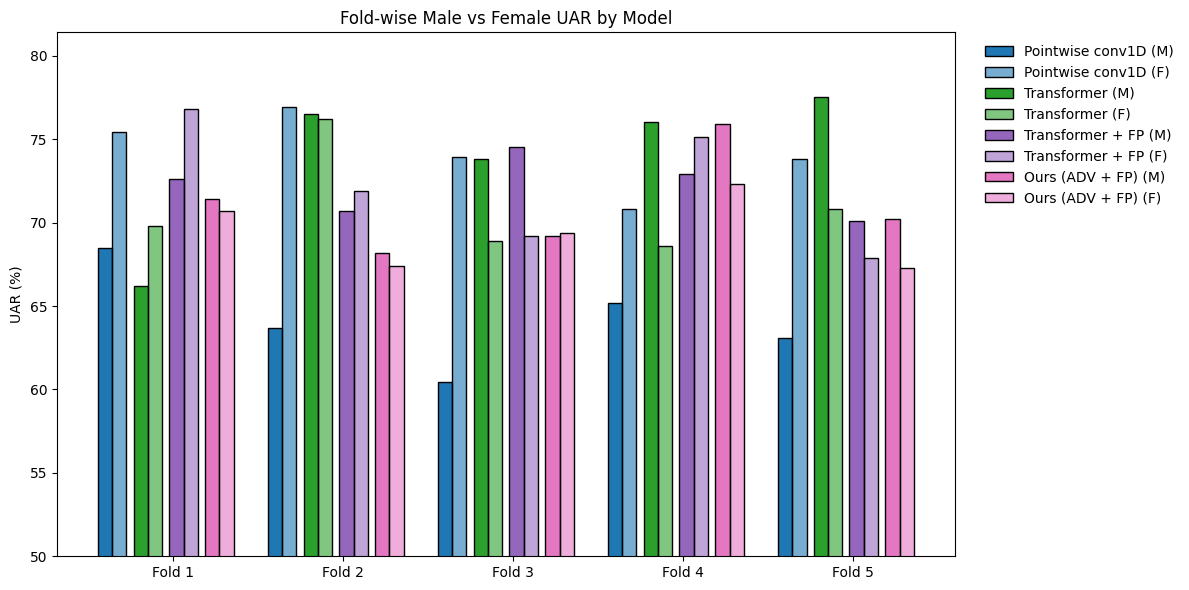

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# 5-fold UAR (%) for each model and gender
models = ['Pointwise conv1D', 'Transformer', 'Transformer + FP', 'Ours (ADV + FP)']
male_folds = np.array([
    [68.45, 63.69, 60.42, 65.18, 63.10],
    [66.22, 76.49, 73.81, 76.04, 77.53],
    [72.62, 70.68, 74.55, 72.92, 70.09],
    [71.43, 68.15, 69.20, 75.89, 70.24],
])
female_folds = np.array([
    [75.45, 76.93, 73.96, 70.83, 73.81],
    [69.79, 76.19, 68.90, 68.60, 70.83],
    [76.79, 71.88, 69.20, 75.15, 67.86],
    [70.68, 67.41, 69.35, 72.32, 67.26],
])

n_models, n_folds = male_folds.shape
folds = np.arange(1, n_folds + 1)

# choose a harmonious palette
cmap = plt.get_cmap('tab10')
base_colors = [cmap(i) for i in [0, 2, 4, 6]]
male_colors   = base_colors
female_colors = [(r, g, b, 0.6) for (r, g, b, a) in base_colors]

# layout parameters
total_group_width = 0.8    # total span of one fold group
gap_multiplier = 0.5       # gap = 0.5 * bar_width
den = 2*n_models + gap_multiplier*(n_models - 1)
bar_width = total_group_width / den
gap_width = gap_multiplier * bar_width

fig, ax = plt.subplots(figsize=(12, 6))

# compute starting offset to center groups at each fold
group_width = 2*bar_width + gap_width  # span of one model pair
total_span = n_models*group_width - gap_width  # total width of all pairs
start_offset = - total_span / 2

for m in range(n_models):
    # x positions for male and female bars of model m
    x_male   = folds + start_offset + m*group_width
    x_female = x_male + bar_width

    ax.bar(
        x_male,
        male_folds[m],
        bar_width,
        label=f'{models[m]} (M)',
        color=male_colors[m],
        edgecolor='k'
    )
    ax.bar(
        x_female,
        female_folds[m],
        bar_width,
        label=f'{models[m]} (F)',
        color=female_colors[m],
        edgecolor='k'
    )

# Set y-axis floor at 50%
ax.set_ylim(50, ax.get_ylim()[1])

# center x-ticks under each fold group
tick_positions = folds + start_offset + total_span/2
ax.set_xticks(tick_positions)
ax.set_xticklabels([f'Fold {i}' for i in folds])

# labels and title
ax.set_ylabel('UAR (%)')
ax.set_title('Fold-wise Male vs Female UAR by Model')

# dedupe legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(
    by_label.values(),
    by_label.keys(),
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    frameon=False
)

plt.tight_layout()
plt.show()

### Conduct paired t-test and plot the result

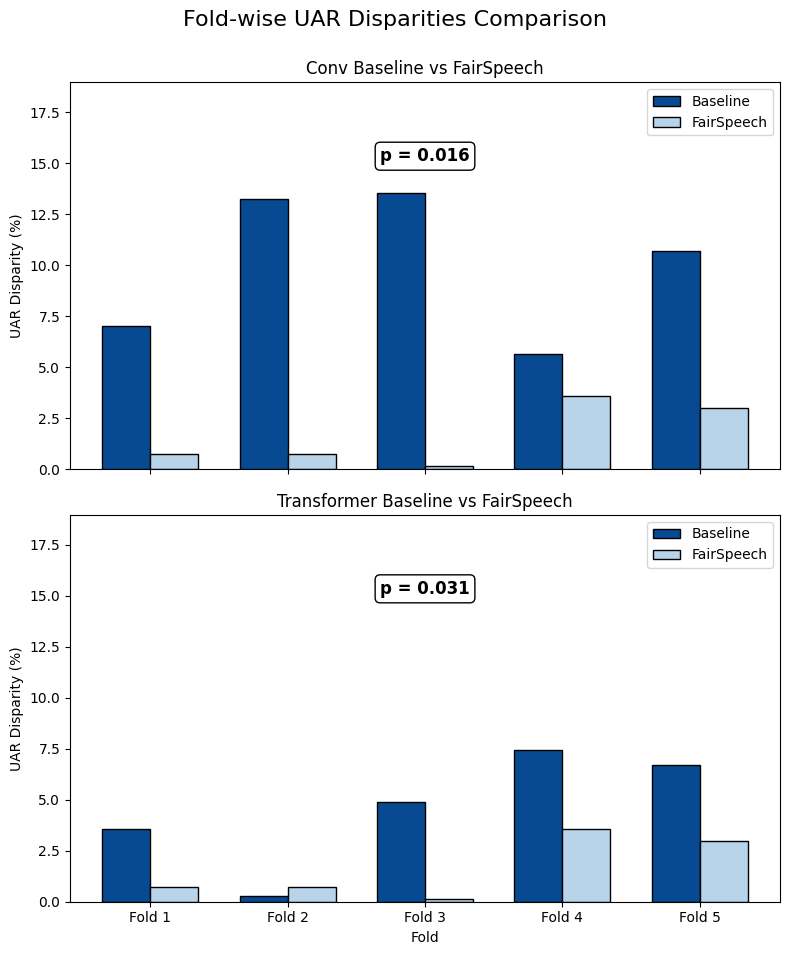

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

# Load the UAR disparities from your computed metrics
conv_baseline        = np.array(metrics['conv_baseline']['disparities_pct'])
transformer_baseline = np.array(metrics['transformer_baseline']['disparities_pct'])
transformer_fairness_penalty = np.array(metrics['transformer_fairness_penalty']['disparities_pct'])
fairspeech           = np.array(metrics['fairspeech']['disparities_pct'])

folds = np.arange(1, len(conv_baseline) + 1)
width = 0.35

# Paired t‐tests
p_conv  = ttest_rel(conv_baseline, fairspeech).pvalue
p_trans = ttest_rel(transformer_baseline, fairspeech).pvalue

# Two similar blues
blues = plt.get_cmap('Blues')
baseline_color   = blues(0.9)
fairspeech_color = blues(0.3)

# Global y‐limit and annotation height
global_max = max(conv_baseline.max(), transformer_baseline.max(), fairspeech.max())
y_limit    = global_max * 1.4
y_annot    = global_max * 1.1

# Create 2 vertical subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 10), sharex=True, sharey=True)

for ax, baseline, title, p_val in zip(
    axs,
    [conv_baseline, transformer_baseline],
    ['Conv Baseline vs FairSpeech', 'Transformer Baseline vs FairSpeech'],
    [p_conv, p_trans]
):
    # Plot bars
    ax.bar(folds - width/2, baseline,  width,
           label='Baseline',  color=baseline_color,  edgecolor='k')
    ax.bar(folds + width/2, fairspeech, width,
           label='FairSpeech', color=fairspeech_color, edgecolor='k')

    # p‐value annotation
    ax.text(
        x=folds.mean(),
        y=y_annot,
        s=f'p = {p_val:.3f}',
        ha='center', va='bottom',
        fontsize=12, fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='black')
    )

    # Formatting
    ax.set_xticks(folds)
    ax.set_xticklabels([f'Fold {i}' for i in folds])
    ax.set_ylabel('UAR Disparity (%)')
    ax.set_title(title)
    ax.legend()
    ax.set_ylim(0, y_limit)

# Common x-label on bottom plot
axs[-1].set_xlabel('Fold')

plt.suptitle('Fold-wise UAR Disparities Comparison', fontsize=16, y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

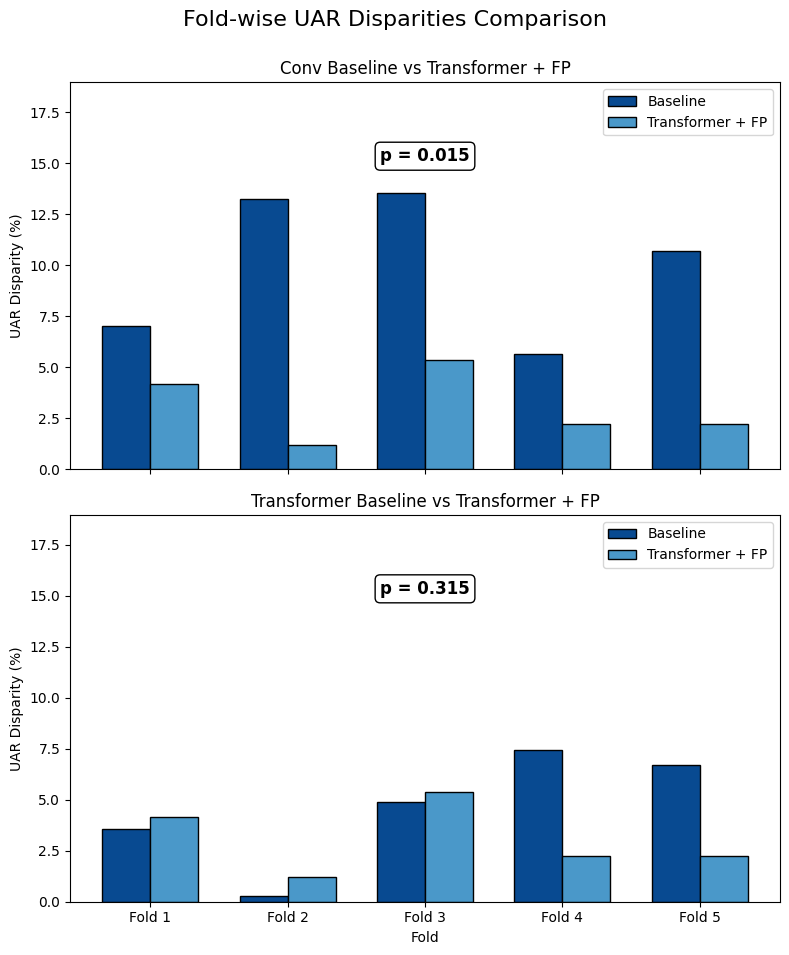

In [7]:
# Paired t‐tests
p_conv  = ttest_rel(conv_baseline, transformer_fairness_penalty).pvalue
p_trans = ttest_rel(transformer_baseline, transformer_fairness_penalty).pvalue

# Two similar blues
blues = plt.get_cmap('Blues')
baseline_color   = blues(0.9)
transformer_fairness_penalty_color = blues(0.6)

# Global y‐limit and annotation height
global_max = max(conv_baseline.max(), transformer_baseline.max(), transformer_fairness_penalty.max())
y_limit    = global_max * 1.4
y_annot    = global_max * 1.1

# Create 2 vertical subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 10), sharex=True, sharey=True)

for ax, baseline, title, p_val in zip(
    axs,
    [conv_baseline, transformer_baseline],
    ['Conv Baseline vs Transformer + FP', 'Transformer Baseline vs Transformer + FP'],
    [p_conv, p_trans]
):
    # Plot bars
    ax.bar(folds - width/2, baseline,  width,
           label='Baseline',  color=baseline_color,  edgecolor='k')
    ax.bar(folds + width/2, transformer_fairness_penalty, width,
           label='Transformer + FP', color=transformer_fairness_penalty_color, edgecolor='k')

    # p‐value annotation
    ax.text(
        x=folds.mean(),
        y=y_annot,
        s=f'p = {p_val:.3f}',
        ha='center', va='bottom',
        fontsize=12, fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='black')
    )

    # Formatting
    ax.set_xticks(folds)
    ax.set_xticklabels([f'Fold {i}' for i in folds])
    ax.set_ylabel('UAR Disparity (%)')
    ax.set_title(title)
    ax.legend()
    ax.set_ylim(0, y_limit)

# Common x-label on bottom plot
axs[-1].set_xlabel('Fold')

plt.suptitle('Fold-wise UAR Disparities Comparison', fontsize=16, y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Qualitative analysis

In [8]:
#!/usr/bin/env python3
import os
# Enable deterministic cuBLAS
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
import yaml
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import DataLoader


from src.models.feature_extractor import FeatureExtractor
from src.models.transformer_encoder import TransformerClassifier
from src.models.pointwise_conv_classifier import PointwiseConv1DClassifier
from src.data.RAVDESS_dataset import RAVDESSDataset

import random
import numpy as np

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# cuDNN
torch.backends.cudnn.benchmark = False  # don’t autotune kernels
torch.backends.cudnn.deterministic = True  # force deterministic kernels
# PyTorch 1.8+
torch.use_deterministic_algorithms(True)

# If you use DataLoader with multiple workers, also:
os.environ["PYTHONHASHSEED"] = str(SEED)

def collate_fn(batch, max_seq_len, downsample_factor):
    waveforms, emos, gens, aids = zip(*batch)
    max_audio = max_seq_len * downsample_factor
    cropped = [(w[:max_audio] if w.shape[0] > max_audio else w) for w in waveforms]
    lengths = [w.shape[0] for w in cropped]
    max_len = max(lengths)
    B = len(cropped)
    padded = torch.zeros(B, max_len)
    for i, w in enumerate(cropped):
        padded[i, : w.shape[0]] = w
    emos = torch.tensor(emos, dtype=torch.long)
    gens = torch.tensor(gens, dtype=torch.long)
    aids = torch.tensor(aids, dtype=torch.long)
    return padded, emos, gens, aids

/home/lgbin81/miniconda3/envs/fairspeech/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load model (baseline/fairspeech)

In [9]:
from pathlib import Path
import yaml
import torch

def load_fold_model(
    out_dir: str | Path,
    fold_idx: int
) -> tuple[torch.nn.Module, torch.nn.Module, dict, torch.device]:
    """
    주어진 out_dir와 fold_idx에 맞춰 FeatureExtractor와 TransformerClassifier (또는 Conv1DClassifier)를
    로드하고, config, device 정보를 반환합니다.

    Args:
        out_dir (str or Path): 로그/체크포인트 루트 디렉토리 (예: 'logs/transformer_baseline')
        fold_idx (int): 불러올 fold 번호

    Returns:
        fe (nn.Module): feature extractor (eval 모드)
        clf (nn.Module): classifier (eval 모드)
        cfg (dict): 사용된 YAML config
        device (torch.device): 모델이 로드된 장치
    """
    from src.models.transformer_encoder import TransformerClassifier
    from src.models.pointwise_conv_classifier import PointwiseConv1DClassifier
    from src.models.feature_extractor import FeatureExtractor

    out_dir = Path(out_dir)
    fold_dir = out_dir / f"fold_{fold_idx}"

    # 1) config 로드
    cfg_path = fold_dir / "used_config.yaml"
    if not cfg_path.exists():
        raise FileNotFoundError(f"Config not found at {cfg_path}")
    with open(cfg_path, "r") as f:
        cfg = yaml.safe_load(f)

    # 2) device 설정
    device = torch.device(cfg["device"])

    # 3) FeatureExtractor 로드
    fe = FeatureExtractor(
        model_type=cfg["model"]["type"],
        pretrained_model_name_or_path=cfg["model"]["pretrained"],
        trainable=False,
        use_weighted_sum=cfg["model"].get("use_weighted_sum", False),
    ).to(device)
    fe.eval()

    # 4) Classifier 인스턴스화
    clf_type = cfg["model"].get("classifier", "transformer").lower()
    speaker_norm = cfg["model"].get("speaker_wise_normalization", False)

    if clf_type == "transformer":
        tconf = cfg["transformer"]
        clf = TransformerClassifier(
            feature_dim=fe.model.config.hidden_size,
            input_dim=tconf["input_dim"],
            num_layers=tconf["num_layers"],
            nhead=tconf["nhead"],
            dim_feedforward=tconf["dim_feedforward"],
            num_emotions=cfg["training"].get("num_emotions", 7),
            num_genders=cfg["training"].get("num_genders", 2),
            dropout=tconf["dropout"],
            pool=tconf["pool"],
            speaker_wise_normalization=speaker_norm,
            predict_gender=tconf.get("predict_gender", False),
        )
    else:
        conv_h = cfg["conv1d"]["hidden_dim"]
        conv_d = cfg["conv1d"]["dropout"]
        clf = PointwiseConv1DClassifier(
            input_dim=fe.model.config.hidden_size,
            hidden_dim=conv_h,
            num_emotions=cfg["training"]["num_emotions"],
            dropout=conv_d,
            speaker_wise_normalization=speaker_norm,
        )

    clf = clf.to(device)
    clf.eval()

    # 5) 체크포인트 로드
    fe_ckpt = torch.load(fold_dir / "best_fe.pt", map_location=device)
    clf_ckpt = torch.load(fold_dir / "best_clf.pt", map_location=device)
    fe.load_state_dict(fe_ckpt)
    clf.load_state_dict(clf_ckpt)

    return fe, clf, cfg, device

### Find the wrong classification

In [10]:
import torch
import librosa
from glob import glob
import os

def find_misclassified(
    data_root: str,
    clf: torch.nn.Module,
    fe: torch.nn.Module,
    emotion: str,
    device: torch.device,
    emotion_labels: dict[int, str],
    sr: int = 16000,
):
    """
    Female 화자 happy 음성 중에서 잘못 분류된 파일(path, pred_label)을 반환.

    Args:
        data_root: RAVDESS 오디오가 있는 루트 디렉토리,
                   예: "data/RAVDESS_audio/processed"
        clf: TransformerClassifier (eval 모드)
        fe: feature extractor (eval 모드)
        device: torch.device
        emotion_labels: {idx: name} 매핑
        sr: 샘플링 레이트 (기본 16000)

    Returns:
        List of tuples (audio_path, true_label, pred_label)
    """
    # emotion_labels 역매핑: name → idx
    label2idx = {v: k for k, v in emotion_labels.items()}
    true_idx = label2idx.get(emotion)
    if true_idx is None:
        raise ValueError(f"'{emotion}'에 해당하는 emotion_labels 항목이 없습니다.")

    # female happy 파일 리스트
    # 사용할 actor 번호
    actor_ids = [22, 24]

    # female/Actor_22 와 female/Actor_24 의 happy 음성만 모으기
    audio_paths = []
    for aid in actor_ids:
        pattern = os.path.join(data_root, "female", f"Actor_{aid}", f"{emotion}", "*.wav")
        audio_paths.extend(glob(pattern))

    misclassified = []
    clf.eval(); fe.eval()

    for path in audio_paths:
        # 1) load & preprocess
        waveform, _ = librosa.load(path, sr=sr, mono=True)
        x = torch.tensor(waveform).unsqueeze(0).to(device)  # (1, T)

        # 2) feature 추출 및 예측
        with torch.no_grad():
            feats = fe(x)
            if isinstance(feats, tuple):
                feats = feats[-1]
            emo_logits, _ = clf(feats)
            pred_idx = int(emo_logits.argmax(dim=-1).cpu().item())

        # 3) 잘못 분류된 경우 기록
        if pred_idx != true_idx:
            pred_label = emotion_labels.get(pred_idx, str(pred_idx))
            misclassified.append((path, f"{emotion}", pred_label))

    return misclassified

In [11]:
from pathlib import Path

out_dir = Path("logs/transformer_fairspeech")
fold_idx = 4

fe, clf, cfg, device = load_fold_model(out_dir, fold_idx)

emotion_labels = {
    0: 'neutral', 1: 'happy', 2: 'sad', 3: 'angry',
    4: 'fearful', 5: 'disgust', 6: 'surprised'
}

mis = find_misclassified(
    data_root="data/RAVDESS_audio/processed",
    clf=clf, fe=fe, device=device,
    emotion="sad",
    emotion_labels=emotion_labels
)

for path, true_lbl, pred_lbl in mis:
    print(f"{path}  → true: {true_lbl:>5s}, pred: {pred_lbl}")

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/lgbin81/miniconda3/envs/fairspeech/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


data/RAVDESS_audio/processed/female/Actor_22/sad/03-01-04-01-01-01-22.wav  → true:   sad, pred: neutral
data/RAVDESS_audio/processed/female/Actor_22/sad/03-01-04-02-02-02-22.wav  → true:   sad, pred: disgust
data/RAVDESS_audio/processed/female/Actor_22/sad/03-02-04-01-02-02-22.wav  → true:   sad, pred: neutral
data/RAVDESS_audio/processed/female/Actor_22/sad/03-01-04-01-01-02-22.wav  → true:   sad, pred: neutral
data/RAVDESS_audio/processed/female/Actor_22/sad/03-02-04-02-02-01-22.wav  → true:   sad, pred: neutral
data/RAVDESS_audio/processed/female/Actor_22/sad/03-02-04-02-02-02-22.wav  → true:   sad, pred: neutral
data/RAVDESS_audio/processed/female/Actor_22/sad/03-02-04-02-01-02-22.wav  → true:   sad, pred: neutral
data/RAVDESS_audio/processed/female/Actor_22/sad/03-02-04-01-01-02-22.wav  → true:   sad, pred: neutral
data/RAVDESS_audio/processed/female/Actor_24/sad/03-02-04-01-01-02-24.wav  → true:   sad, pred: fearful
data/RAVDESS_audio/processed/female/Actor_24/sad/03-01-04-01-01-

### Show the classification result and attention map

In [ ]:
import torch
import librosa
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def extract_attention_maps(
    audio_path: str,
    fe: torch.nn.Module,
    clf: torch.nn.Module,
    device: torch.device,
    lambda_grl: float = 1.0
):
    """
    audio_path → list of (H, L, L) attention maps per layer
    """
    waveform, sr = librosa.load(audio_path, sr=16000, mono=True)
    inp = torch.tensor(waveform).unsqueeze(0).to(device)

    fe.eval(); clf.eval()
    with torch.no_grad():
        feats = fe(inp)
        if isinstance(feats, tuple):
            feats = feats[-1]

        # 분류 logits
        emo_logits, gender_logits = clf(feats, lambda_grl=lambda_grl)

        # self-attn 준비
        feats_norm = clf.channel_norm(feats)
        proj        = clf.input_proj(feats_norm)
        x = proj.permute(1, 0, 2)
        if clf.pool == "cls":
            cls_tok = clf.cls_token.expand(1, -1, -1).permute(1,0,2)
            x = torch.cat([cls_tok, x], dim=0)

        maps = []
        for layer in clf.transformer.layers:
            attn = layer.self_attn(x, x, x)[1]  # (1,H,L,L) or (1,L,L)
            arr  = attn[0].cpu().numpy()
            if arr.ndim == 2:
                arr = arr[np.newaxis,...]
            maps.append(arr)  # list of (H, L, L)
    return emo_logits, gender_logits, maps

def compare_attention_maps(
    audio_path: str,
    model1: tuple[torch.nn.Module, torch.nn.Module, str],
    model2: tuple[torch.nn.Module, torch.nn.Module, str],
    device: torch.device,
    emotion_labels: dict[int,str] = None,
    lambda_grl: float = 1.0,
    vmax: float = 0.5
):
    fe1, clf1, title1 = model1
    fe2, clf2, title2 = model2

    # 1) 각각 분류 결과와 어텐션 맵 추출
    emo1, gen1, maps1 = extract_attention_maps(audio_path, fe1, clf1, device, lambda_grl)
    emo2, gen2, maps2 = extract_attention_maps(audio_path, fe2, clf2, device, lambda_grl)

    def print_classification(name, emo_logits, gender_logits):
        probs = torch.softmax(emo_logits, dim=-1).cpu().numpy()[0]
        pred = int(probs.argmax())
        label = emotion_labels.get(pred, str(pred)) if emotion_labels else str(pred)
        print(f"--- {name} Classification ---")
        print(f"Predicted emotion: {label} (idx={pred})")
        for i,p in enumerate(probs):
            n = emotion_labels.get(i,str(i)) if emotion_labels else str(i)
            print(f"  {n:>10s}: {p:.3f}")
        if gender_logits is not None:
            gprob = torch.softmax(gender_logits,dim=-1).cpu().numpy()[0]
            gpred = int(gprob.argmax())
            print(f"Predicted gender idx: {gpred}, probs={np.round(gprob,3)}")
        print()

    # 2) print both models' classification
    print_classification(title1, emo1, gen1)
    print_classification(title2, emo2, gen2)

    # 3) attention maps indexing
    arr1 = maps1[0].squeeze(0)  # (L, L)
    arr2 = maps2[0].squeeze(0)  # (L, L)

    # 4) plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    for ax, amap, ttl in zip(
        axes, [arr1, arr2], [title1, title2]
    ):
        im = ax.imshow(amap,
                       cmap='viridis',
                       aspect='auto',
                       vmin=0.0,
                       vmax=vmax)
        ax.set_title(f"{ttl}")
        ax.set_xlabel("Key index")
        ax.set_ylabel("Query index")

    # 컬러바 생성 및 레이블 설정
    im = axes[-1].imshow(
        arr2, cmap='viridis', aspect='auto', vmin=0.0, vmax=vmax
    )

    # 오른쪽에 작은 축(cax) 하나 만들어서 거기에 컬러바 그리기
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  
    # [left, bottom, width, height] — 0~1 normalized figure coordinates
    cbar = fig.colorbar(
        im,
        cax=cax,
        orientation='vertical'
    )
    cbar.set_label("Attention Weight", rotation=90, labelpad=5)

    plt.suptitle("Attention Map Comparison", y=0.98, fontsize=16)

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/lgbin81/miniconda3/envs/fairspeech/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- Transformer Baseline Classification ---
Predicted emotion: 0 (idx=0)
           0: 0.612
           1: 0.008
           2: 0.343
           3: 0.000
           4: 0.019
           5: 0.017
           6: 0.001

--- FairSpeech Classification ---
Predicted emotion: 2 (idx=2)
           0: 0.299
           1: 0.011
           2: 0.568
           3: 0.002
           4: 0.021
           5: 0.098
           6: 0.001



/tmp/ipykernel_3064/1387533596.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


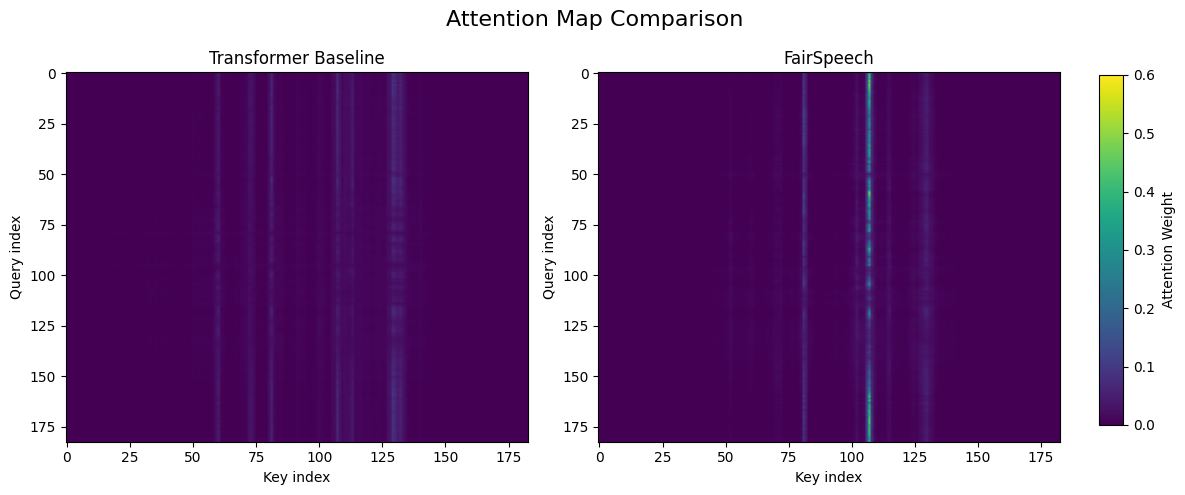

In [ ]:
from pathlib import Path

actor_id = 22
emotion = 'Sad'
gender = 'female' if actor_id % 2 ==0 else 'male'

# 감정 레이블 매핑 예시
emotion_labels = {
    0: 'neutral', 1: 'happy', 2: 'sad', 3: 'angry',
    4: 'fearful', 5: 'disgust', 6: 'surprised'
}

audio_file = f"data/RAVDESS_audio/processed/{gender}/Actor_{actor_id}/{emotion.lower()}/03-01-04-01-02-01-{actor_id}.wav"

# 1) FairSpeech 모델 로드
out1 = Path("logs/transformer_fairspeech")
fe_fs, clf_fs, cfg_fs, dev = load_fold_model(out1, fold_idx=4)

# 2) Transformer Baseline 모델 로드
out2 = Path("logs/transformer_baseline")
fe_bl, clf_bl, cfg_bl, _ = load_fold_model(out2, fold_idx=4)

# 3) 비교 그리기 (예: layer 2, head 3)
compare_attention_maps(
    audio_file,
    model1=(fe_bl, clf_bl, "Transformer Baseline"),
    model2=(fe_fs, clf_fs, "FairSpeech"),
    device=dev,
    lambda_grl=1.0,
    vmax=0.6
)